In [1]:
from IPython.display import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# inline plotting instead of popping out
%matplotlib inline
import os, sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)
from lib import *
from keras.datasets import cifar10
from keras.utils import np_utils

C:\Users\KirtyVedula\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 1)


In [ ]:
# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

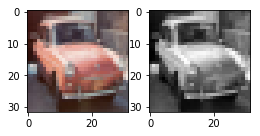

In [3]:
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.21, dtype=dtype), np.asarray(.72, dtype=dtype), np.asarray(.07, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

X_train_gray = grayscale(X_train)
X_test_gray = grayscale(X_test)

# now we have only one channel in the images
img_channels = 1

# plot a randomly chosen image
img = 64
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(X_train[img], interpolation='none')
plt.subplot(1, 2, 2)
plt.imshow(X_train_gray[img, :, :, 0], cmap=plt.get_cmap('gray'), interpolation='none')
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
X_train_gray, X_val_gray, Y_train, Y_val = train_test_split(X_train_gray, Y_train, test_size=0.2, random_state=0)

X_train_gray = np.squeeze(X_train_gray)
X_val_gray = np.squeeze(X_val_gray)
Y_train = np.squeeze(Y_train)
Y_val = np.squeeze(Y_val)

print('X_train_gray shape:', X_train_gray.shape)
print('X_val_gray shape:', X_val_gray.shape)

print('Y_train shape:', Y_train.shape)
print('Y_val shape:', Y_val.shape)

X_train_gray = X_train_gray.astype('float32') / 255.
X_test_gray = X_test_gray.astype('float32') / 255.
X_train_gray = X_train_gray.reshape((len(X_train_gray), np.prod(X_train_gray.shape[1:])))
X_test_gray = X_test_gray.reshape((len(X_test_gray), np.prod(X_test_gray.shape[1:])))
print(X_train_gray.shape)
print(X_test_gray.shape)

X_train_gray shape: (40000, 32, 32)
X_val_gray shape: (10000, 32, 32)
Y_train shape: (40000,)
Y_val shape: (10000,)
(40000, 1024)
(10000, 1024)


In [5]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 512 # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(1024,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(1024, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [6]:
autoencoder.fit(X_train_gray, X_train_gray,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_gray, X_test_gray))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 14s - loss: 0.6523 - val_loss: 0.6292
Epoch 2/50
40000/40000 [==============================] - 12s - loss: 0.6213 - val_loss: 0.6178
Epoch 3/50
40000/40000 [==============================] - 12s - loss: 0.6142 - val_loss: 0.6120
Epoch 4/50
40000/40000 [==============================] - 9s - loss: 0.6103 - val_loss: 0.6103
Epoch 5/50
40000/40000 [==============================] - 10s - loss: 0.6083 - val_loss: 0.6080
Epoch 6/50
40000/40000 [==============================] - 8s - loss: 0.6064 - val_loss: 0.6067
Epoch 7/50
40000/40000 [==============================] - 8s - loss: 0.6044 - val_loss: 0.6066
Epoch 8/50
40000/40000 [==============================] - 9s - loss: 0.6036 - val_loss: 0.6043
Epoch 9/50
40000/40000 [==============================] - 10s - loss: 0.6030 - val_loss: 0.6034
Epoch 10/50
40000/40000 [==============================] - 9s - loss: 0.6019 - val_loss: 0

In [11]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = autoencoder.predict(X_test_gray)
decoded_imgs = autoencoder.predict(encoded_imgs)

In [ ]:
# definition to show original image and reconstructed image
n = 12
%matplotlib inline
plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test_gray[i].reshape(32,32))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(encoded_imgs[i].reshape(32,32))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

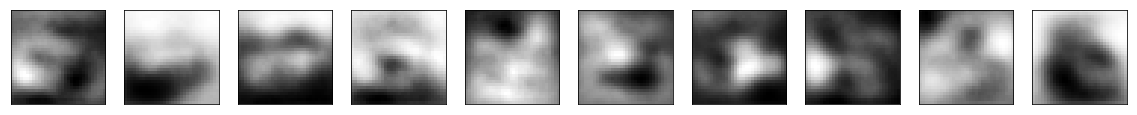

In [22]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(32,32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()